<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/example%20LLM%20fact%20checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install langdetect --quiet

In [4]:
# --- Corrected and HF_TOKEN-aware Imports ---
import torch
from torch.utils.data import Dataset, DataLoader
# Import AdamW from torch.optim, not transformers
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification
# -------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd
import numpy as np
from langdetect import detect
import re
from urllib.parse import urlparse
import logging
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:


# --- Import for accessing Colab Secrets ---
try:
    from google import colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

HF_TOKEN = None
if IN_COLAB:
    try:
        # Access the secret named 'HF_TOKEN'
        HF_TOKEN = colab.userdata.get('HF_token_example')
        if HF_TOKEN:
            print("HF_TOKEN successfully loaded from Colab secrets.")
        else:
            print("Warning: HF_TOKEN secret exists but is empty.")
    except Exception as e:
        print(f"Warning: Could not load HF_TOKEN from Colab secrets: {e}")
        print("Proceeding without token. This might fail for private models.")
else:
    # If not in Colab, you might load it from environment variables (e.g., locally)
    # import os
    # HF_TOKEN = os.environ.get('HF_TOKEN')
    # if not HF_TOKEN:
    #     print("Warning: HF_TOKEN not found in environment variables.")
    print("Not running in Colab. HF_TOKEN loading logic for local environments can be added here.")
    pass

# Set up logging for better debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Proceeding without token. This might fail for private models.


In [7]:


# --- 1. Data Loading and Preprocessing (Medical Domain Specific) ---

def load_and_preprocess_medical_data(file_path_or_url=None, visualize=True):
    """
    Loads and preprocesses a medical fact-checking dataset.
    This example uses simulated data. In practice, you'd load from a real source.
    Optionally visualizes data characteristics.
    """
    logger.info("Loading and preprocessing medical fact-checking data...")

    # --- Simulate Loading Medical Data ---
    np.random.seed(42) # For reproducibility
    base_claims_supported = [
        "Aspirin is effective for treating headaches.",
        "Regular exercise reduces the risk of heart disease.",
        "Penicillin is an antibiotic used to treat bacterial infections.",
        "The human body has 206 bones.",
        "Vaccines prevent serious infectious diseases.",
        "Antibiotics are effective against bacterial infections.",
        "Smoking increases the risk of lung cancer.",
        "Washing hands frequently helps prevent the spread of germs.",
        "Insulin is used to manage blood sugar levels in diabetics.",
        "MRI scans are useful for imaging soft tissues."
    ]

    base_claims_refuted = [
        "Taking vitamin D supplements can prevent COVID-19.",
        "Homeopathy is proven to cure cancer.",
        "Antibiotics are effective against viral infections like the flu.",
        "Drinking bleach can cure coronavirus.",
        "Vaccines cause autism.",
        "MRI scans use ionizing radiation.",
        "Eating carrots significantly improves night vision for everyone.",
        "You must drink exactly 8 glasses of water every day.",
        "Shaving makes your hair grow back thicker.",
        "Cracking your knuckles causes arthritis.",
        "Humans only use 10% of their brains.",
        "Sugar makes all children hyperactive.",
        "Reading in dim light permanently damages your eyesight.",
        "Swimming after eating causes cramps and drowning.",
        "Chicken soup is a proven cure for the common cold.",
        "Organic food is always more nutritious than conventional food.",
        "The Earth is flat.",
        "The Sun revolves around the Earth.",
        "Blood is blue inside your body.",
        "We lose most of our body heat through our heads.",
    ]

    # Simulate a larger, imbalanced dataset (~90% Refuted)
    num_supported = 50
    num_refuted = int(0.9 * (len(base_claims_supported) + len(base_claims_refuted)) * 10)

    supported_claims = np.random.choice(base_claims_supported, size=num_supported, replace=True).tolist()
    refuted_claims = np.random.choice(base_claims_refuted, size=num_refuted, replace=True).tolist()

    all_claims = supported_claims + refuted_claims
    all_verdicts = ['Supported by Evidence'] * len(supported_claims) + ['Refuted by Evidence'] * len(refuted_claims)

    combined = list(zip(all_claims, all_verdicts))
    np.random.shuffle(combined)
    claims_shuffled, verdicts_shuffled = zip(*combined)
    claims_shuffled, verdicts_shuffled = list(claims_shuffled), list(verdicts_shuffled)

    data = {
        'medical_claim': claims_shuffled,
        'evidence_url': [f"https://pubmed.ncbi.nlm.nih.gov/example{i%100 + 1}" for i in range(len(claims_shuffled))],
        'verdict': verdicts_shuffled
    }
    df = pd.DataFrame(data)
    logger.info(f"Loaded initial simulated medical data with {len(df)} rows.")

    if visualize:
        plt.figure(figsize=(8, 5))
        verdict_counts = df['verdict'].value_counts()
        sns.barplot(x=verdict_counts.index, y=verdict_counts.values, palette='viridis')
        plt.title('Distribution of Medical Claim Verdicts (Simulated)')
        plt.xlabel('Verdict')
        plt.ylabel('Number of Claims')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        logger.info("Displayed verdict distribution bar chart.")

    # --- Language Filtering ---
    def get_language_from_url(url):
        try:
            domain = urlparse(url).netloc
            if any(tld in domain for tld in ['.gov', '.org', '.edu', '.ac.uk', '.edu.au', '.nih.gov', '.cdc.gov', '.com']):
                 return 'en'
            elif '.fr' in domain:
                return 'fr'
            elif '.es' in domain:
                return 'es'
            return 'unknown'
        except:
            return 'unknown'

    df['lang_from_url'] = df['evidence_url'].apply(get_language_from_url)
    df['lang_from_claim'] = df['medical_claim'].apply(lambda x: detect(x) if pd.notnull(x) and x else 'unknown')

    df_filtered = df[(df['lang_from_claim'] == 'en') & (df['lang_from_url'] == 'en')].copy()
    logger.info(f"Filtered to {len(df_filtered)} English medical claims based on language detection.")

    # --- Simulate Evidence Text Retrieval ---
    simulated_evidence_texts = []
    successful_retrievals = []

    for index, row in df_filtered.iterrows():
        claim = row['medical_claim']
        verdict = row['verdict']
        url = row['evidence_url']
        try:
            avg_words_per_sentence = 15
            num_sentences = np.random.randint(1000 // avg_words_per_sentence, 5000 // avg_words_per_sentence)
            evidence_snippet = f"This medical article discusses the claim: '{claim}'. "
            evidence_snippet += f"After reviewing clinical studies and medical literature, experts conclude this claim is {verdict.lower()}. "
            evidence_snippet += " ".join(["This is a sentence providing detailed medical context and evidence. "] * num_sentences)
            simulated_evidence_texts.append(evidence_snippet[:512 * 10])
            successful_retrievals.append(True)
        except Exception as e:
            logger.warning(f"Failed to simulate evidence retrieval for {url}: {e}")
            simulated_evidence_texts.append("")
            successful_retrievals.append(False)

    df_filtered['evidence_text'] = simulated_evidence_texts
    df_filtered['retrieval_success'] = successful_retrievals

    df_final = df_filtered[df_filtered['retrieval_success'] == True].copy()
    df_final.drop(columns=['lang_from_url', 'lang_from_claim', 'retrieval_success'], inplace=True)
    logger.info(f"Final medical dataset after removing failed retrievals: {len(df_final)} rows.")

    # --- Label Encoding ---
    label_map = {'Supported by Evidence': 1, 'Refuted by Evidence': 0}
    df_final['label'] = df_final['verdict'].map(label_map)
    df_final.dropna(subset=['label'], inplace=True)
    df_final['label'] = df_final['label'].astype(int)

    if visualize and len(df_final) > 0:
        plt.figure(figsize=(8, 5))
        final_verdict_counts = df_final['verdict'].value_counts()
        sns.barplot(x=final_verdict_counts.index, y=final_verdict_counts.values, palette='magma')
        plt.title('Final Distribution of Medical Claim Verdicts (After Filtering)')
        plt.xlabel('Verdict')
        plt.ylabel('Number of Claims')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        logger.info("Displayed final verdict distribution bar chart.")

    return df_final

# --- 2. Dataset Class for RoBERTa (Medical Domain Specific) ---

class MedicalFactCheckingDataset(Dataset):
    """
    Custom Dataset class for loading medical claim-evidence pairs for RoBERTa fine-tuning.
    """
    def __init__(self, claims, evidences, labels, tokenizer, max_length=512):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = str(self.claims[idx])
        evidence = str(self.evidences[idx])
        label = self.labels[idx]

        input_text = f"Medical Claim: {claim} Medical Evidence: {evidence}"

        encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- 3. Model Training and Evaluation (Medical Domain Specific with Visualizations) ---

def train_and_evaluate_medical_baseline(model_name='roberta-base', epochs=3, batch_size=8, learning_rate=2e-5, visualize=True):
    """
    Main function to load medical data, prepare model, train, and evaluate the RoBERTa baseline,
    including visualizations of the process and results. Uses HF_TOKEN for model loading.
    """
    logger.info("Starting RoBERTa baseline training and evaluation for Medical Fact-Checking...")

    # 1. Load and preprocess medical data
    df = load_and_preprocess_medical_data(visualize=visualize)
    if df.empty:
        logger.error("No medical data available after preprocessing. Exiting.")
        return None, None, 0, "No data"

    # 2. Prepare data for training
    claims = df['medical_claim'].tolist()
    evidences = df['evidence_text'].tolist()
    labels = df['label'].tolist()

    train_claims, val_claims, train_evidences, val_evidences, train_labels, val_labels = train_test_split(
        claims, evidences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    if visualize:
        split_data = pd.DataFrame({
            'Split': ['Train'] * len(train_labels) + ['Validation'] * len(val_labels),
            'Label': train_labels + val_labels
        })
        label_names = {0: 'Refuted', 1: 'Supported'}
        split_data['Label_Name'] = split_data['Label'].map(label_names)

        plt.figure(figsize=(12, 5))
        ax1 = plt.subplot(1, 2, 1)
        split_counts = split_data['Split'].value_counts()
        sns.barplot(x=split_counts.index, y=split_counts.values, palette='Set2', ax=ax1)
        ax1.set_title('Data Split Sizes')
        ax1.set_ylabel('Number of Samples')

        ax2 = plt.subplot(1, 2, 2)
        crosstab_df = pd.crosstab(split_data['Split'], split_data['Label_Name'])
        crosstab_df.plot(kind='bar', ax=ax2, color=['salmon', 'skyblue'])
        ax2.set_title('Label Distribution in Splits')
        ax2.set_xlabel('Data Split')
        ax2.set_ylabel('Count')
        ax2.legend(title='Verdict')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        logger.info("Displayed data split visualization.")

    # 3. Load tokenizer and model using HF_TOKEN
    logger.info(f"Loading tokenizer and model '{model_name}' from Hugging Face...")
    try:
        # Pass the token when loading from_pretrained
        tokenizer_kwargs = {"use_auth_token": HF_TOKEN} if HF_TOKEN else {}
        model_kwargs = {"use_auth_token": HF_TOKEN} if HF_TOKEN else {}

        tokenizer = RobertaTokenizer.from_pretrained(model_name, **tokenizer_kwargs)
        model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2, **model_kwargs)
        logger.info("Tokenizer and model loaded successfully.")
    except Exception as e:
        logger.error(f"Failed to load tokenizer or model '{model_name}': {e}")
        return None, None, 0, f"Load Error: {e}"


    # 4. Create Datasets and DataLoaders
    train_dataset = MedicalFactCheckingDataset(train_claims, train_evidences, train_labels, tokenizer)
    val_dataset = MedicalFactCheckingDataset(val_claims, val_evidences, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 5. Setup optimizer and device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # 6. Training Loop with Loss Tracking
    model.train()
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / num_batches
        train_losses.append(avg_train_loss)
        logger.info(f'Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}')

    if visualize and len(train_losses) > 1:
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='b')
        plt.title('RoBERTa Training Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        logger.info("Displayed training loss curve.")

    # 7. Evaluation Loop
    model.eval()
    predictions, true_labels, prediction_probs = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            predictions_batch = torch.argmax(logits, dim=-1)

            predictions.extend(predictions_batch.cpu().numpy())
            true_labels.extend(labels_batch.cpu().numpy())
            prediction_probs.extend(probs.cpu().numpy()[:, 1]) # Prob for positive class

    # 8. Calculate Metrics
    accuracy = accuracy_score(true_labels, predictions)
    report_dict = classification_report(true_labels, predictions, target_names=['Refuted by Evidence', 'Supported by Evidence'], digits=4, output_dict=True)
    report_str = classification_report(true_labels, predictions, target_names=['Refuted by Evidence', 'Supported by Evidence'], digits=4)
    cm = confusion_matrix(true_labels, predictions)

    logger.info("----- RoBERTa Medical Fact-Checking Baseline Evaluation Results -----")
    logger.info(f"Validation Accuracy: {accuracy:.4f}")
    logger.info("Classification Report:")
    print(report_str)
    logger.info("---------------------------------------------------------------------")

    if visualize and len(true_labels) > 0 and len(prediction_probs) > 0:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Refuted', 'Supported'],
                    yticklabels=['Refuted', 'Supported'])
        plt.title('Confusion Matrix for RoBERTa Medical Fact-Checker')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
        logger.info("Displayed confusion matrix.")

        fpr, tpr, _ = roc_curve(true_labels, prediction_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        logger.info(f"Displayed ROC curve (AUC = {roc_auc:.2f}).")

        precision, recall, _ = precision_recall_curve(true_labels, prediction_probs)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
        p_prior = np.sum(true_labels) / len(true_labels)
        plt.axhline(y=p_prior, color='r', linestyle='--', label=f'Random Guess Baseline (P={p_prior:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        logger.info(f"Displayed Precision-Recall curve (AUC = {pr_auc:.2f}).")

        refuted_f1 = report_dict['Refuted by Evidence']['f1-score']
        supported_f1 = report_dict['Supported by Evidence']['f1-score']

        plt.figure(figsize=(8, 5))
        classes = ['Refuted by Evidence', 'Supported by Evidence']
        f1_scores = [refuted_f1, supported_f1]
        colors = ['lightcoral', 'lightgreen']

        bars = plt.bar(classes, f1_scores, color=colors)
        plt.title('RoBERTa Baseline F1 Scores by Class')
        plt.xlabel('Class')
        plt.ylabel('F1 Score')
        plt.ylim(0, 1.05)

        for bar, score in zip(bars, f1_scores):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{score:.3f}', ha='center', va='bottom')

        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        logger.info("Displayed per-class F1 score bar chart.")

    return model, tokenizer, accuracy, report_dict


/tmp/ipython-input-1505425322.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=verdict_counts.index, y=verdict_counts.values, palette='viridis')


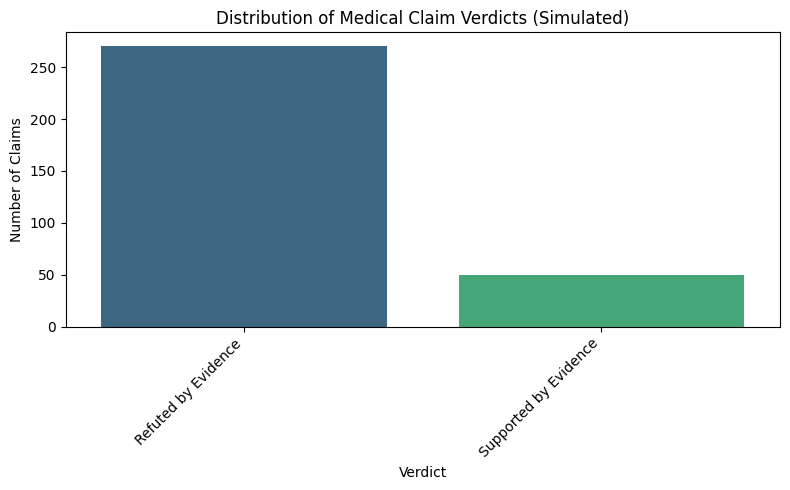

/tmp/ipython-input-1505425322.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_verdict_counts.index, y=final_verdict_counts.values, palette='magma')


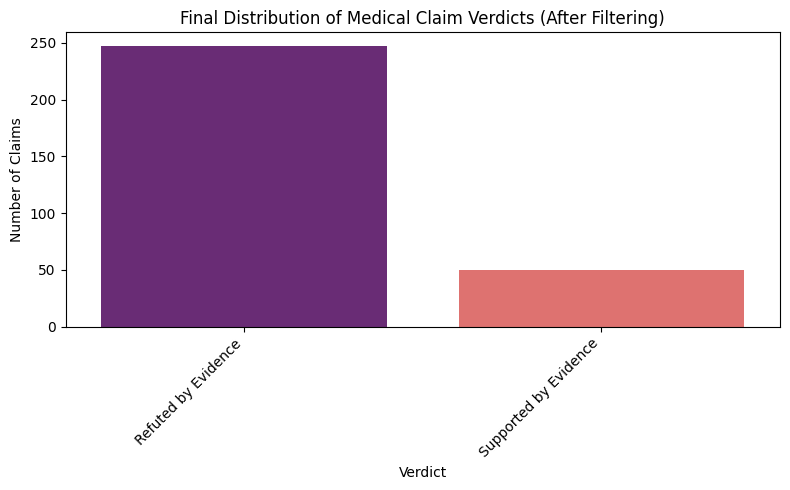

/tmp/ipython-input-1505425322.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_counts.index, y=split_counts.values, palette='Set2', ax=ax1)


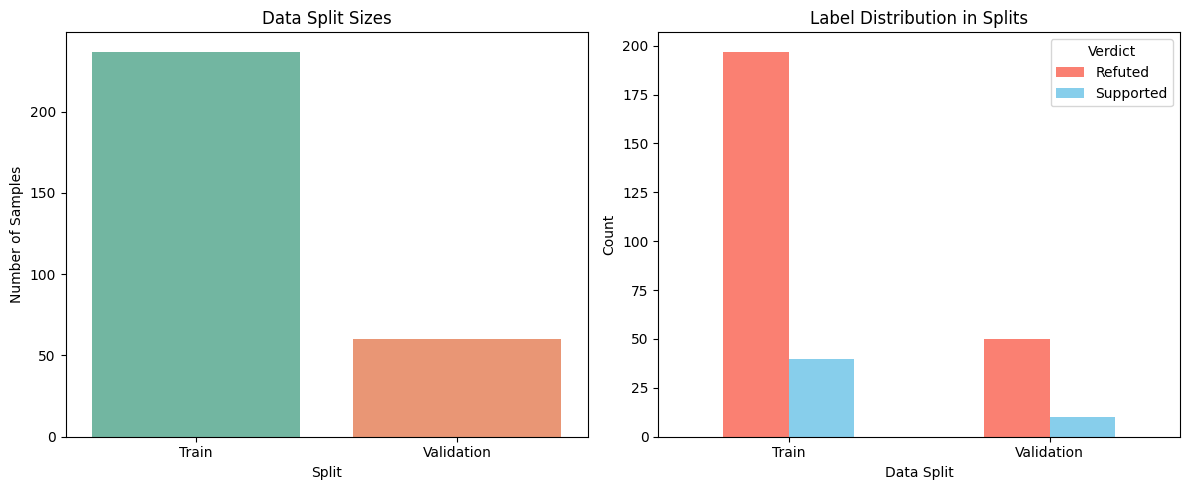

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

    # Run the main training and evaluation process for the medical domain with visualizations
    try:
        trained_model, trained_tokenizer, final_accuracy, final_report = train_and_evaluate_medical_baseline(
            model_name='roberta-base', # Can be a private model if HF_TOKEN is valid
            epochs=7,
            batch_size=8,
            learning_rate=2e-5,
            visualize=True
        )
        if trained_model is not None:
            print("\nMedical RoBERTa baseline training and evaluation completed successfully.")
            print(f"Final Validation Accuracy: {final_accuracy:.4f}")
            # Save model/tokenizer if needed (token not required for saving locally)
            # trained_model.save_pretrained('./roberta_medical_factcheck_model')
            # trained_tokenizer.save_pretrained('./roberta_medical_factcheck_model')
        else:
            print("Training failed or no data was available.")
    except Exception as e:
        logger.error(f"An error occurred during medical training/evaluation: {e}")
